# Exploring featurization

- First example (abalone) quadratic features don't improve performance.
    - Ask people to theorize why.
    - If the conditional expectation function is truly linear, then extra features won't help.
    - Show joint density plots to give some hand-waving evidence.
- Second example we do get a performance bump. Note the sample size is small so it's not particularly robust.

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Abalone example

In [30]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'abalone/abalone.data',
                 header=None)

df = df.rename(columns={
    0:'sex', 1:'length', 2:'diameter', 3:'height',
    4:'whole_weight', 5:'shucked_weight', 6:'viscera_weight',
    7:'shell_weight', 8:'rings'
})

categorical = ['sex']

numeric = ['length', 'diameter', 'height',
        'whole_weight', 'shucked_weight',
        'shell_weight']

train_X, test_X, train_y, test_y = train_test_split(df.drop('rings', axis=1),
                                                    df['rings'],
                                                    random_state=42)

In [31]:
class OneHotStrings(TransformerMixin):
    
    def __init__(self):    
        self.labeler = LabelEncoder()
        self.enc = OneHotEncoder()
        
    def fit(self,X):
        self.labeler.fit(X)
        _X = self.labeler.transform(X).reshape(-1,1)
        self.enc.fit(_X)
        return X
    
    def transform(self,X):
        _X = self.labeler.transform(X).reshape(-1,1)
        return self.enc.transform(_X)

In [32]:
mapper = DataFrameMapper(
    [(col, None) for col in numeric] + \
    [(col, OneHotStrings()) for col in categorical])

pipe = Pipeline([
    ('mapper',mapper),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

pipe.fit(train_X, train_y)

print('Train score: ',pipe.score(train_X, train_y))
print('Test score: ',pipe.score(test_X, test_y))

Train score:  0.528393673016
Test score:  0.534127249172


In [33]:
poly_mapper = DataFrameMapper(
    [(numeric, PolynomialFeatures(degree=2))] + \
    [(col, OneHotStrings()) for col in categorical])

pipe_poly = Pipeline([
    ('mapper',poly_mapper),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

pipe_poly.fit(train_X, train_y)

print('Train score: ',pipe_poly.score(train_X, train_y))
print('Test score: ',pipe_poly.score(test_X, test_y))

Train score:  0.559442492704
Test score:  0.554318625419


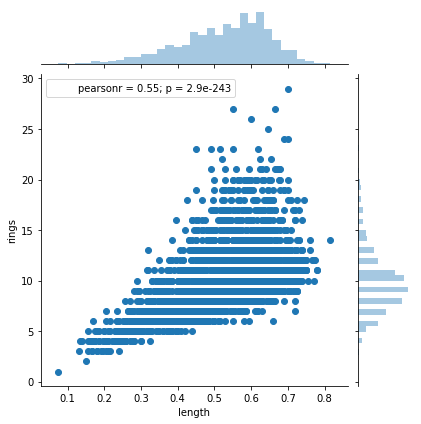

In [40]:
sns.jointplot(train_X['length'], train_y)
plt.savefig('figures/abalone_linear.png')

# Boston example
Boston housing get boost using poly features...

In [71]:
from sklearn.datasets import load_boston

In [72]:
data = load_boston()
df = data.data
cols = ['CRIM','ZN','INDUS','CHAS','NOX',
        'RM','AGE','DIS','RAD','TAX',
        'PTRATIO','B','LSTAT']
df = pd.DataFrame(df, columns=cols)
train_X, test_X, train_y, test_y = train_test_split(df, data.target,
                                                    test_size=0.2,
                                                    random_state = 2142018)

In [73]:
categorical = ['CHAS','RAD']
numeric = ['CRIM','ZN','INDUS','NOX','RM',
        'AGE','DIS','TAX','PTRATIO','B',
        'LSTAT']

In [87]:
mapper = DataFrameMapper(
    [(col, None) for col in numeric] + \
    [(col, OneHotStrings()) for col in categorical])

pipe = Pipeline([
    ('mapper',mapper),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.5, .7, .9, .95, .99, 1],
                         normalize=True))
])

pipe.fit(train_X, train_y)

print('Train score: ',pipe.score(train_X, train_y))
print('Test score: ',pipe.score(test_X, test_y))

Train score:  0.762945577283
Test score:  0.645054949322


In [91]:
mapper2 = DataFrameMapper(
    [(numeric, PolynomialFeatures(degree=2))] + \
    [(col, OneHotStrings()) for col in categorical])

pipe2 = Pipeline([
    ('mapper',mapper2),
    ('clf', ElasticNetCV(cv=10,
                         l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                         normalize=True))
])

pipe2.fit(train_X, train_y)

print('Train score: ',pipe2.score(train_X, train_y))
print('Test score: ',pipe2.score(test_X, test_y))

Train score:  0.879364391327
Test score:  0.816386882677
